In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

## confirm number of subjects, neurons, trials

In [ ]:
# norm_choice = 'shortest_baseline'
# norm_choice = 'session_baseline'
norm_choice = 'nothing'
print(f'df normalized by {norm_choice}\n')

df = pd.read_pickle(f'./data_files/neuron_by_trial_norm_by_{norm_choice}.pkl')
print(f'{df["neuron"].nunique()} total neurons\n')

# identify neurons with zero firing rate in encoding or baseline
zero_FR_neurons = df[(df['FR'] == 0) & (df['stim_phase'].isin(['encoding', 'baseline']))]['neuron'].unique()
print(f'{len(zero_FR_neurons)} neurons dropped because FR = 0 in encoding or baseline: {zero_FR_neurons}\n')

# drop these neurons
df_filtered = df[~df['neuron'].isin(zero_FR_neurons)]
df_encoding = df_filtered[df_filtered['stim_phase'] == 'encoding']
num_subjs, num_sess, num_neurons = len(np.unique(df_encoding['subj'])), len(np.unique(df_encoding['sess'])), len(np.unique(df_encoding['neuron']))

print(f'{num_neurons} neurons, {num_sess} sessions, {num_subjs} subjects')
print(f'{len(df_encoding)} rows in df\n')

no_fMRI_subjs = ['P49', 'P55', 'P56', 'P57', 'P58']
print(f'subjs who didnt undergo fMRI: {no_fMRI_subjs}\n')

scene_cells = ['P42CS_R1_47_2_1347_7', 'P42CS_R2_42_3_1096_7', 'P43CS_R1_59_3_1929_1', 'P43CS_R1_76_4_1276_10', 'P43CS_R2_29_1_2303_2',
               'P44CS_R1_15_2_835_8', 'P47CS_R1_10_2_900_8', 'P47CS_R1_18_1_1631_4', 'P47CS_R1_22_4_1379_4', 'P47CS_R1_68_1_964_9',
               'P47CS_R1_74_2_1575_10', 'P47CS_R1_78_1_2233_10', 'P47CS_R2_19_2_3139_4', 'P47CS_R2_20_4_2437_4', 'P47CS_R2_47_1_1478_7',
               'P48CS_R1_9_1_678_8', 'P48CS_R1_21_2_873_4', 'P48CS_R1_30_1_1720_2', 'P48CS_R1_43_2_3181_7', 'P48CS_R2_48_2_936_7',
               'P48CS_R2_58_8_6571_1', 'P49CS_R1_7_1_2581_6', 'P49CS_R2_67_1_1165_10', 'P51CS_R1_48_1_2072_8', 'P51CS_R2_40_3_2542_5',
               'P51CS_R2_80_1_794_9', 'P53CS_R1_10_1_2456_8', 'P53CS_R2_6_4_5480_6', 'P53CS_R2_16_2_6444_8', 'P54CS_R1_17_2_3943_4',
               'P54CS_R1_45_1_2172_7', 'P54CS_R1_54_3_4177_3', 'P54CS_R1_55_2_6861_3', 'P54CS_R1_56_1_1540_3', 'P54CS_R1_70_3_5181_10',
               'P54CS_R2_13_4_7736_8', 'P54CS_R2_67_1_4703_10', 'P55CS_R2_18_2_1050_4', 'P55CS_R2_45_1_1206_7', 'P55CS_R2_48_1_36_7',
               'P56CS_R1_9_1_3423_8', 'P56CS_R1_13_1_999_8', 'P56CS_R1_19_1_1458_4', 'P57CS_R1_66_1_2442_10', 'P57CS_R2_9_1_740_8',
               'P57CS_R2_15_2_1738_8', 'P57CS_R2_70_2_1978_10', 'P58CS_R1_34_3_3299_5', 'P58CS_R1_34_4_3301_5', 'P58CS_R1_35_4_2476_5',
               'P58CS_R1_56_1_3134_3', 'P58CS_R1_57_3_2783_1', 'P58CS_R1_60_1_1424_1', 'P58CS_R1_62_2_3305_1', 'P58CS_R1_63_2_3170_1',
               'P60CS_R1_39_1_1408_5', 'P60CS_R1_54_1_571_3', 'P60CS_R1_56_1_1106_3', 'P62CS_R1_30_3_6240_3', 'P62CS_R2_22_2_2532_7']

sessions_with_scene_cells = np.unique([cell[:8] for cell in scene_cells])
print(f'{len(sessions_with_scene_cells)} sessions with scene cells: {sessions_with_scene_cells}\n')

print(f'{len(scene_cells)} scene selective cells')

df_encoding.head()


df normalized by session_baseline

1457 total neurons

19 neurons dropped because FR = 0 in encoding or baseline: ['P43CS_R2_76_1_990_10' 'P47CS_R1_19_4_1280_4' 'P47CS_R1_52_1_298_3'
 'P47CS_R2_22_1_8375_4' 'P48CS_R1_24_1_2297_4' 'P48CS_R1_57_1_753_1'
 'P48CS_R2_58_3_6420_1' 'P48CS_R2_62_2_2097_1' 'P49CS_R2_64_1_4257_1'
 'P51CS_R2_48_4_5337_7' 'P53CS_R1_37_1_3731_5' 'P54CS_R1_70_2_5145_10'
 'P54CS_R2_31_1_2534_2' 'P55CS_R1_49_2_5469_3' 'P55CS_R1_54_1_3978_3'
 'P57CS_R2_51_1_624_3' 'P62CS_R1_27_3_8498_3' 'P62CS_R1_29_3_8468_3'
 'P62CS_R1_32_6_6115_3']

1438 neurons, 29 sessions, 16 subjects
1438 rows in df

subjs who didnt undergo fMRI: ['P49', 'P55', 'P56', 'P57', 'P58']

25 sessions with scene cells: ['P42CS_R1' 'P42CS_R2' 'P43CS_R1' 'P43CS_R2' 'P44CS_R1' 'P47CS_R1'
 'P47CS_R2' 'P48CS_R1' 'P48CS_R2' 'P49CS_R1' 'P49CS_R2' 'P51CS_R1'
 'P51CS_R2' 'P53CS_R1' 'P53CS_R2' 'P54CS_R1' 'P54CS_R2' 'P55CS_R2'
 'P56CS_R1' 'P57CS_R1' 'P57CS_R2' 'P58CS_R1' 'P60CS_R1' 'P62CS_R1'
 'P62CS_R2']

60 scen

,subj,sess,neuron,region,start_time,stop_time,RT,trial_spikes,trial_aligned_spikes,num_spikes,FR,trial_smooth_spikes,trial_smooth_FR,stim_phase,stimulus_file,response_correct,response_confidence,actual_response
0,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,0.0,478.85512,478.85512,"[3.43207675, 4.39507675, 5.16801325, 5.2624507...","[3.43207675, 4.39507675, 5.16801325, 5.2624507...",360,0.751793,"[-0.6092685994051223, 0.7375356729640957, 1.41...",0.594349,encoding,bd_movie,NaN,NaN,NaN
42,P41,P41CS_R1,P41CS_R1_38_1_613_5,ACC,0.0,478.85512,478.85512,"[0.2510465, 2.07970175, 4.70126325, 5.09220075...","[0.2510465, 2.07970175, 4.70126325, 5.09220075...",278,0.580551,"[-0.25286009928907993, 0.2651947382787911, 0.2...",-0.303030,encoding,bd_movie,NaN,NaN,NaN
84,P41,P41CS_R1,P41CS_R1_39_1_1359_5,ACC,0.0,478.85512,478.85512,"[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...","[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...",949,1.981810,"[-0.6957983571254145, -0.6957983571254145, -0....",-0.063182,encoding,bd_movie,NaN,NaN,NaN
126,P41,P41CS_R1,P41CS_R1_40_1_2816_5,ACC,0.0,478.85512,478.85512,"[0.0642965, 0.80051525, 0.813359, 0.89145275, ...","[0.0642965, 0.80051525, 0.813359, 0.89145275, ...",1820,3.800732,"[-0.602277248152551, -0.31964434957816956, 0.5...",1.392814,encoding,bd_movie,NaN,NaN,NaN
168,P41,P41CS_R1,P41CS_R1_40_2_2821_5,ACC,0.0,478.85512,478.85512,"[0.4351715, 0.88882775, 1.79107775, 3.7156705,...","[0.4351715, 0.88882775, 1.79107775, 3.7156705,...",379,0.791471,"[0.3434182842192856, -0.257563713164464, -0.85...",0.321909,encoding,bd_movie,NaN,NaN,NaN


## get scene cut info

In [3]:
cuts_df = pd.read_csv('../assets/annotations/scenecut_info.csv')
cuts = cuts_df['shot_start_t'].tolist()

# 1st frame is always a scene cut
scene_cut_inds = [0]
# find the indices of scene cuts
scene_cut_inds.extend(np.where(np.diff(cuts_df['scene_id']) != 0)[0] + 1)

print(f'{len(scene_cut_inds)} scene cuts at indices {scene_cut_inds}')

cuts_df['cut_colors'] = 'grey'
cuts_df.loc[scene_cut_inds, 'cut_colors'] = 'red'
cuts_df.head(15)

13 scene cuts at indices [0, 7, 8, 9, 11, 42, 45, 58, 59, 60, 79, 80, 81]


,scene_id,shot_start_fr,shot_start_t,shot_dur_t,location,cut_type,cut_dur_t,cut_dur_fr,cut_colors
0,1.0,1.0,0.00,4.72,backyard,cut,0.00,0,red
1,1.0,119.0,4.72,10.28,backyard,cut,0.00,0,grey
2,1.0,376.0,15.00,1.72,backyard,cut,0.00,0,grey
3,1.0,419.0,16.72,2.36,backyard,cut,0.00,0,grey
4,1.0,478.0,19.08,2.64,backyard,cut,0.00,0,grey
5,1.0,544.0,21.72,3.36,backyard,cut,0.00,0,grey
6,1.0,628.0,25.08,2.00,backyard,cut,0.00,0,grey
7,2.0,678.0,27.08,10.56,livingroom,fadeout/fadein,0.40,10,red
8,3.0,942.0,37.64,8.52,bedroom,dissolve,0.48,12,red
9,4.0,1155.0,46.16,20.12,bedroom,cut,0.00,0,red


## plot some of the scene selective cells that they found

'Significant proportions of cells were event selective in the vmPFC (10/175, p =  0.005, permutation test) and preSMA (20/299,  p <  0.001) but not in the amygdala (15/479, p =  0.081), ACC (7/236, p =  0.224), and hippocampus (8/261, p = 0.199;  Fig. 7a,b show examples).'

plotting the 60 scene selective cells that they found
42, 42, 43, 43, 43, 

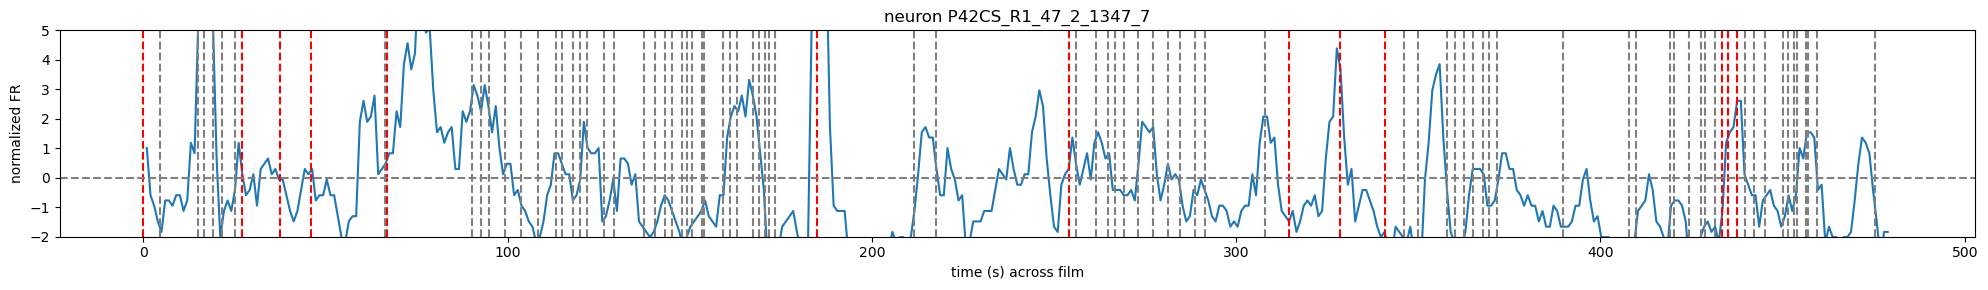

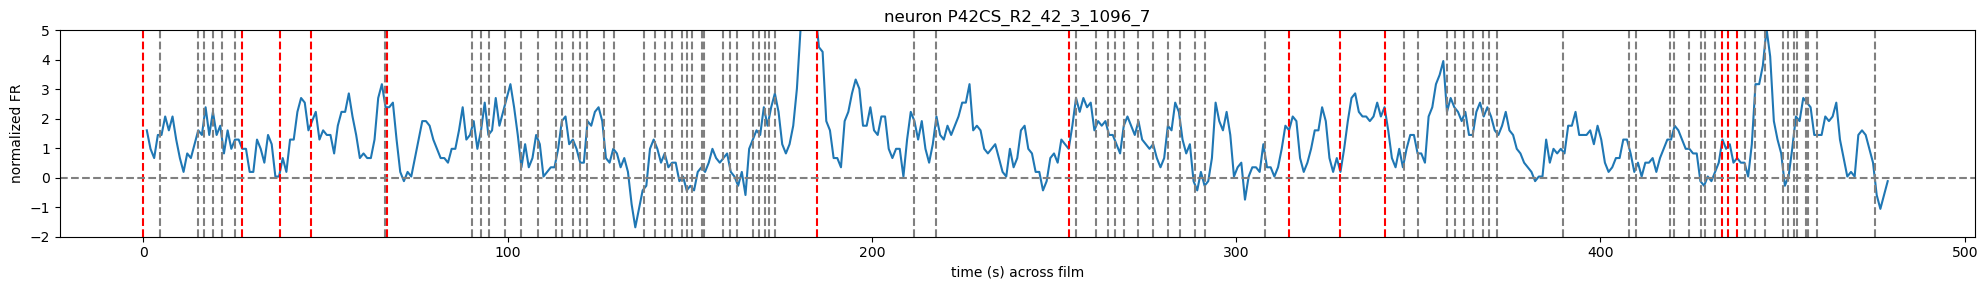

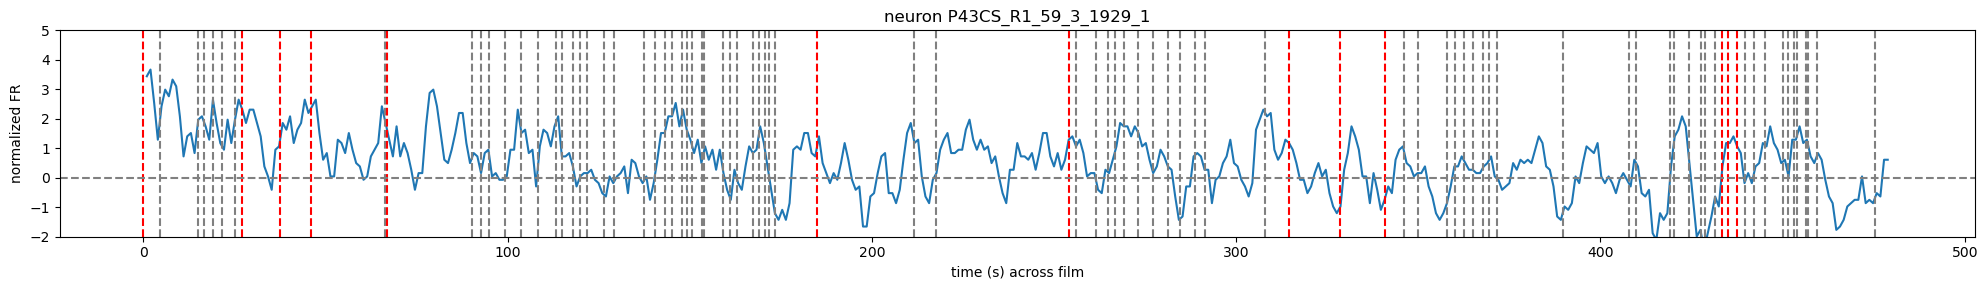

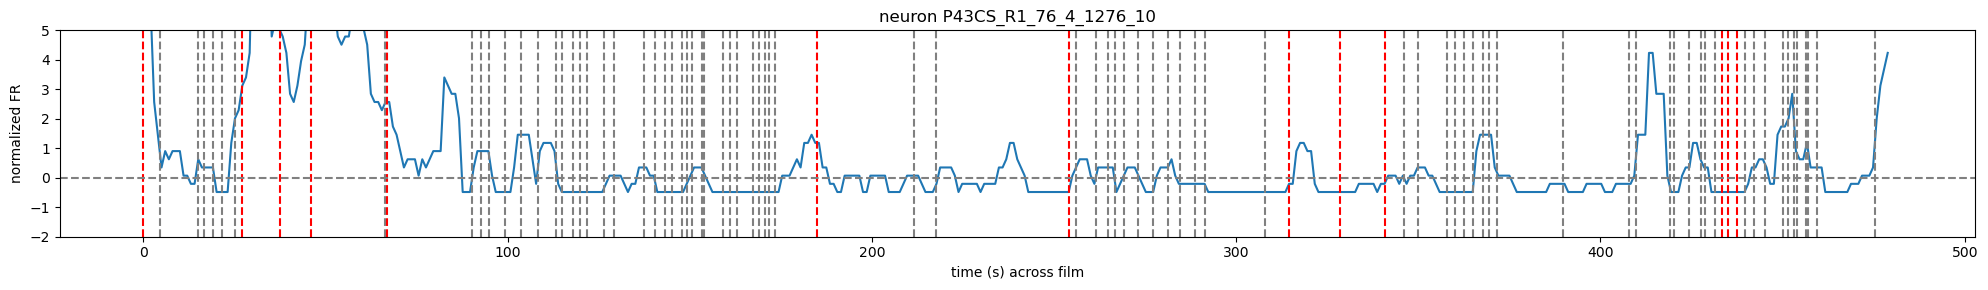

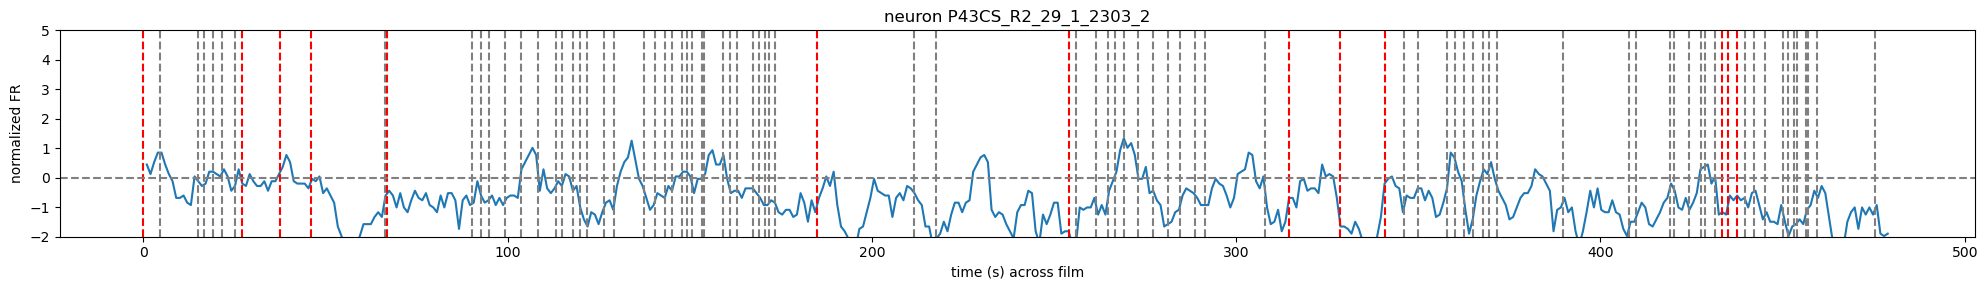

In [4]:
print('plotting the 60 scene selective cells that they found')

for neuron in scene_cells[:5]:

    print(neuron[1:3], end=', ')
    neuron_df = df_encoding[df_encoding['neuron'] == neuron]

    # get the length of the first spike array
    num_bins = len(neuron_df['trial_smooth_spikes'].iloc[0])
    x_time_points = np.linspace(1, np.max(neuron_df['RT']), num_bins)

    plt.figure(figsize=(20, 3))
    plt.plot(x_time_points, neuron_df['trial_smooth_spikes'].iloc[0], label=neuron)

    for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
        plt.axvline(x=cut, color=color, linestyle='--')

    
    plt.xlabel('time (s) across film')
    plt.ylabel('normalized FR')
    plt.title(f'neuron {neuron}')
    plt.ylim(-2, 5)
    plt.axhline(0, color='grey', linestyle='--')
    plt.tight_layout()
plt.show()


## for each subject's 2 sessions, plot region-avged FRs

In [32]:
# region_to_plot = 'ACC'

# # to convert x-axis from bins to time
# num_bins = len(df_encoding['trial_smooth_spikes'].iloc[0])
# x_time_points = np.linspace(1, np.max(df_encoding['RT']), num_bins)

# color_map = {'ACC': 'blue', 'amygdala': 'orange', 'hippocampus': 'green', 'preSMA': 'red', 'vmPFC': 'purple'}

# for subj, subj_df in df_encoding.groupby('subj'):

#     if not subj_df['region'].str.contains(region_to_plot).any():
#         continue

#     fig, axs = plt.subplots(2, 1, figsize=(10, 4))
#     if subj in no_fMRI_subjs:
#         plt.suptitle(f'subj-{subj} sessions (DID NOT UNDERGO fMRI)', fontsize=16)
#     else:
#         plt.suptitle(f'subj-{subj} sessions', fontsize=16)

#     sess_num = 0

#     for session, session_df in subj_df.groupby('sess'):

#         # if not session in sessions_with_scene_cells:
#         #     continue

#         sess_maxFR = 0

#         for region, region_df in session_df.groupby('region'):

#             if not region == region_to_plot:
#                 continue

#             # convert groupby obj to 2d arr
#             smooth_spikes_arr = np.array(region_df['trial_smooth_spikes'].tolist())

#             # get the avg and std smoothed FR across neurons of a region  
#             smooth_FR_region_avg = np.nanmean(smooth_spikes_arr, axis=0)
#             smooth_FR_region_sd = np.nanstd(smooth_spikes_arr, axis=0) 
#             sess_maxFR = max(sess_maxFR, np.nanmax(smooth_FR_region_avg)) # to set ylim for plotting purposes

#             # plot
#             axs[sess_num].plot(x_time_points, smooth_FR_region_avg, label=region, color=color_map.get(region))
#             axs[sess_num].fill_between(x_time_points,
#                                     smooth_FR_region_avg - smooth_FR_region_sd, smooth_FR_region_avg + smooth_FR_region_sd,
#                                     alpha=0.1, color=color_map.get(region))

#         # make vertical lines at each scene cut
#         for cut, color in zip(cuts_df['shot_start_t'], cuts_df['cut_colors']):
#             axs[sess_num].axvline(x=cut, color=color, linestyle='--')

#         axs[sess_num].set_xlabel('time (s) across film', fontsize=12)
#         axs[sess_num].set_ylabel('normalized FR', fontsize=12)
#         axs[sess_num].set_ylim(-2, max(4, sess_maxFR))
#         axs[sess_num].legend(loc='upper right')

#         sess_num += 1

#     plt.tight_layout()  
#     plt.show()



(13, 475)


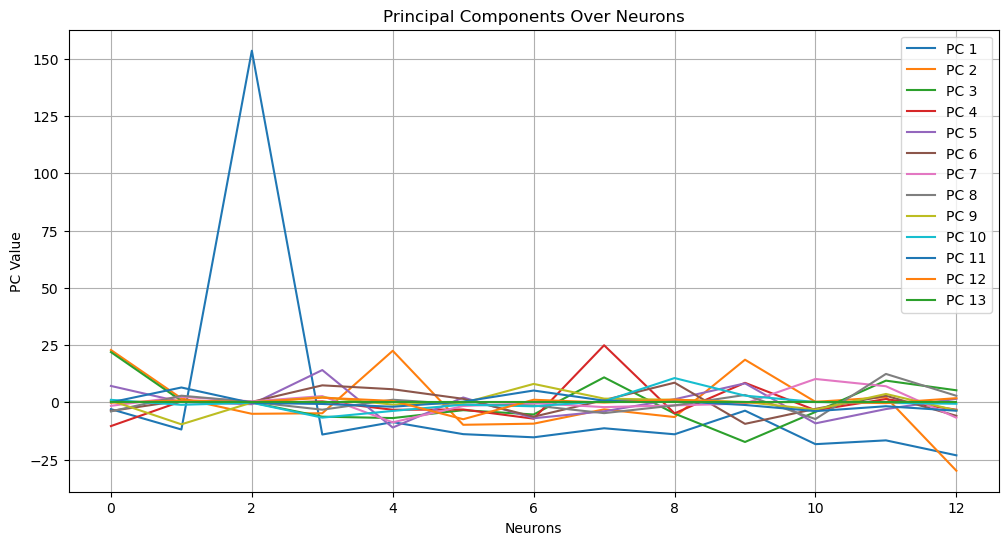

In [43]:
P44CS_R1_ACC_df = df_encoding[(df_encoding['sess'] == 'P44CS_R1') & (df_encoding['region'] == 'ACC')].reset_index(drop=True)
neur_by_time = np.array(P44CS_R1_ACC_df['trial_smooth_spikes'].tolist())
print(neur_by_time.shape)
P44CS_R1_ACC_df.head()

# fig, axs = plt.subplots(neur_by_time.shape[0], 1, figsize=(10, 20))

# for i in range(neur_by_time.shape[0]):
#     axs[i].plot(x_time_points, neur_by_time[i], label=f'Neuron {i+1}')
#     axs[i].set_title(f'Time Series of Neuron {i+1}')
#     axs[i].set_ylim(-2, max(4, max(neur_by_time[i])))

# plt.tight_layout()
# plt.show()

from sklearn.decomposition import PCA
pca = PCA()
neuron_pcs = pca.fit_transform(neur_by_time)

plt.figure(figsize=(12, 6))
for i in range(neuron_pcs.shape[1]):  # Loop over the number of PCs
    plt.plot(neuron_pcs[:, i], label=f'PC {i + 1}')
plt.title('Principal Components Over Neurons')
plt.xlabel('Neurons')
plt.ylabel('PC Value')
plt.legend()
plt.grid()
plt.show()


